In [1]:
import numpy as np
from glob import glob
from keras.applications.vgg16 import VGG16
from keras import backend as K
from tqdm import tqdm
from keras.layers import Lambda
import tensorflow as tf
from keras.models import Model
import cv2
import matplotlib.pyplot as plt
from utils import *
%matplotlib inline

style_image = 'armchair.jpg'

path = 'C://Users/jgolb/Desktop/datasets/JPEGImages/train/*'
img_rows = 672//2 # 672, 376
img_cols = 376//2
channels = 3
img_shape = (img_rows, img_cols, channels)

bs = 2 # batch size

Using TensorFlow backend.


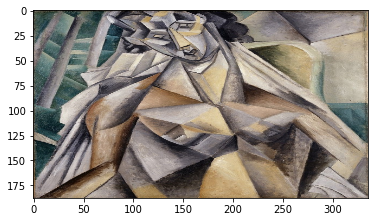

In [2]:
S = cv2.imread('style/'+style_image)
S = cv2.resize(S, img_shape[:2])
plt.imshow(S[:,:,::-1]) # bgr->rgb
tf_style = tf.convert_to_tensor(S[None], dtype='float32') # tensor to evaluate gram matrix

In [3]:
original = Input((img_cols, img_rows, channels), name = 'InputImage')


'''
Now we load a pre-trained VGG16 model, in order to build our perceptual loss.
let:
S - style loss (MSE between the Gram Matrix of the VGG's layers output of the style image and the generated image)
C - content loss (MSE between the VGG's layer\s output of the original image and the generated). In other words, 
    we want the VGG model to recognize the same objects in the generated image as in the original.
V - variation loss (smoothness of the generated image)

our final loss is L = w1 * S + w2 * C + w3 * V
'''

vgg = VGG16(include_top=False, weights='imagenet', 
            input_tensor=Lambda(vgg_preprocess_input)(original))
for l in vgg.layers: l.trainable = False

vgg_content = Model(original, get_output(vgg, 5), name = 'Content-VGG16')
vggc1 = vgg_content(original) # content of original image
vgg_style = Model(original, [get_output(vgg, o, 1) for o in [1,2,3,4,5]], name = 'Style-VGG16')
vggs1 = vgg_style(tf_style) # content of style image - will be used to evaluate the style loss

# Now we calculate the gram matrix of every VGG's layer output when we pass the style image to it.
S = []
for i in range(len(vggs1)):
    S.append(gram_matrix(vggs1[i]))

def style_loss(x):
    style_loss = 0
    n=len(x)
    for i in range(n):
        _, w, h, channels = K.int_shape(x[i])
        size = w * h
        C = gram_matrix(x[i]) # calculate the gram matrix of every VGG's layer output
        loss = K.sum(K.square(S[i] - C), axis = [1,2]) / (4.0 * (channels ** 2) * (size ** 2))
        style_loss += loss/n
    return K.expand_dims(style_loss, 0)

generator = get_generator(img_shape=(img_cols, img_rows, channels)) # load generator model - generating styled images
stylish = generator(original)
vggc2 = vgg_content(stylish) # content of style
vggs2 = vgg_style(stylish) # style of stylished


# Create Losses
loss_con = Lambda(content_fn, name = 'Content')([vggc1, vggc2])
loss_style = Lambda(style_loss, name = 'Style')(vggs2)
loss_var = Lambda(total_variation_loss, name = 'Variation')(stylish)

model = Model(original, [loss_con, loss_style, loss_var], name = 'StyleTransfer')

style_weight = 0.01 # w1
content_weight = 500. # w2
total_variation_weight = 1e-4 # w3


model.compile(optimizer='adam', loss=['mse','mae','mae'], 
              loss_weights=[content_weight, style_weight, total_variation_weight])

In [9]:
data_gen = ImageLoader(glob(path), img_shape[:2], bs, flip=False)

model.fit_generator(data_gen, steps_per_epoch=len(data_gen)//bs, epochs=50, workers=1, use_multiprocessing=False)

In [6]:
data_gen = ImageLoader(glob(path), img_shape[:2], bs, flip=False)
data_gen = iter(data_gen)

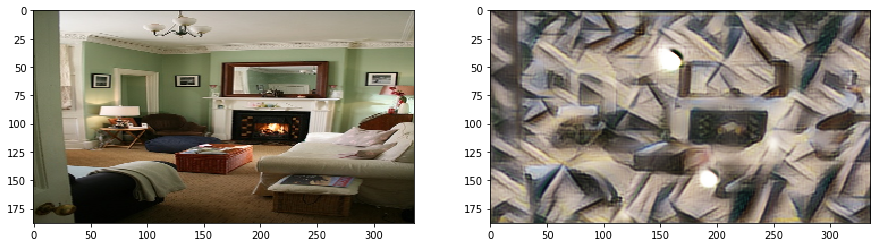

In [33]:
''' Check models performance '''

x,_ = next(data_gen)

style = generator.predict(x)
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.imshow(x[1][:,:,::-1]/255)
plt.subplot(122)
plt.imshow(style[1][:,:,::-1]/255)

In [34]:
generator.save('weights/'+style_image[:-4]+'.h5')
print('model {} saved.'.format(style_image[:-4]))

model armchair saved.
